<a href="https://colab.research.google.com/github/1900690/grape-sky-segmentation/blob/main/grape-sky-binarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#画像から二値化画像を作成する

参考：[デジタルカメラと画像処理ソフト「Fiji-ImageJ」を用いたブドウの葉面積指数の簡易推定技術](https://www.naro.go.jp/laboratory/karc/prefectural_results/files/R02_4_04.pdf)



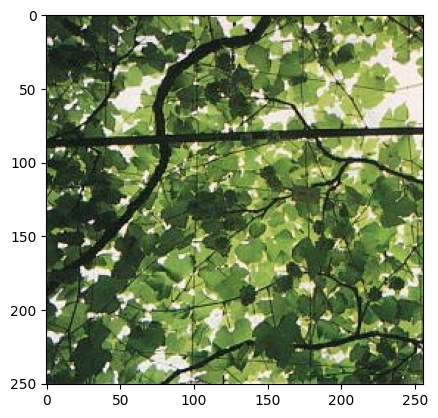

In [6]:
#@title 分析する画像をアップロード（またはサンプル画像で分析）
from google.colab import files

サンプル画像を使用する = True # @param {type:"boolean"}

if サンプル画像を使用する == True:
  !wget -q https://github.com/1900690/grape-sky-segmentation/releases/download/sample/sample.jpg
  #読み込んだ画像を表示
  #・OpenCVを使って画像を読み込む cv2.imreadでOpenCV形式に変換 OpenCVはBGRなのでcvtColorでRGBに直してから表示する
  import cv2
  from matplotlib import pyplot as plt
  uploaded_file_name="/content/sample.jpg"
  orig = cv2.imread(uploaded_file_name)
  src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
  plt.imshow(src)
else:
  uploaded_file = files.upload()
  uploaded_file_name = next(iter(uploaded_file))

  #読み込んだ画像を表示
  #・OpenCVを使って画像を読み込む cv2.imreadでOpenCV形式に変換 OpenCVはBGRなのでcvtColorでRGBに直してから表示する
  import cv2
  from matplotlib import pyplot as plt
  orig = cv2.imread(uploaded_file_name)
  src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
  plt.imshow(src)

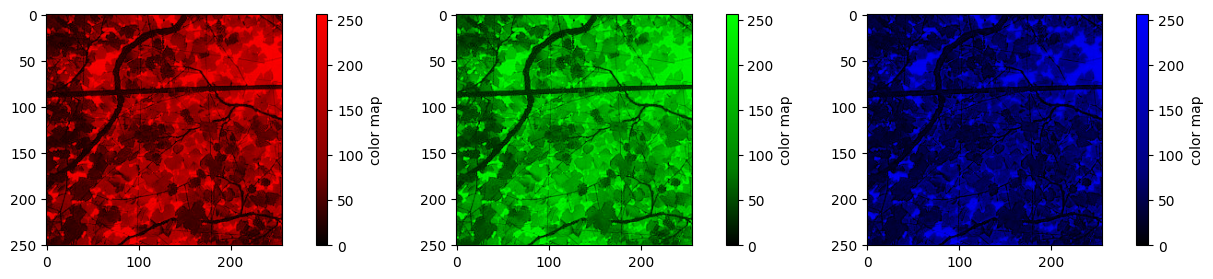

In [7]:
#@title RGBに分けた画像を表示
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#カラーマップ作製
#赤
r1 = np.array([0,0,0]) / 256
r2 = np.array([128,0,0]) / 256
r3 = np.array([192,0,0]) / 256
r4 = np.array([256,0,0]) / 256
cmr = LinearSegmentedColormap.from_list(name='customred', colors=[r1, r2, r3, r4])
#緑
g1 = np.array([0,0,0]) / 256
g2 = np.array([0,128,0]) / 256
g3 = np.array([0,192,0]) / 256
g4 = np.array([0,256, 0]) / 256
cmg = LinearSegmentedColormap.from_list(name='customgreen', colors=[g1, g2, g3, g4])
#青
b1 = np.array([0,0,0]) / 256
b2 = np.array([0,0,128]) / 256
b3 = np.array([0,0,192]) / 256
b4 = np.array([0,0,256]) / 256
cmb = LinearSegmentedColormap.from_list(name='customblue', colors=[b1, b2, b3, b4])

#色の指定の最小値、最大値
vmin,vmax = 0, 256

r = np.array(src[:, :, 0], dtype=np.int16)
g = np.array(src[:, :, 1], dtype=np.int16)
b = np.array(src[:, :, 2], dtype=np.int16)

#図を表示
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(r,cmap = cmr, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,2)
plt.imshow(g,cmap = cmg, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,3)
plt.imshow(b,cmap = cmb, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)

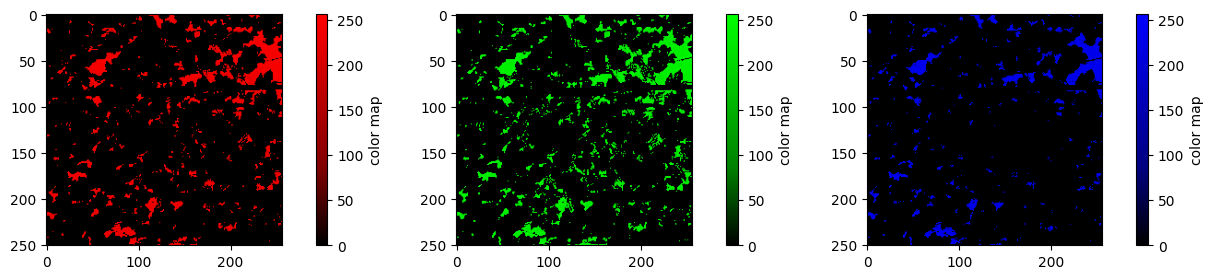

In [8]:
#@title 各色の二値化の基準を決め各色のマスクを作成
#@markdown 赤の閾値
Rmax = 255 # @param {type:"slider", min:0, max:255, step:1}
Rmin = 200 # @param {type:"slider", min:0, max:255, step:1}
#@markdown 緑の閾値
Gmax = 255 # @param {type:"slider", min:0, max:255, step:1}
Gmin = 200 # @param {type:"slider", min:0, max:255, step:1}
#@markdown 青の閾値
Bmax = 255 # @param {type:"slider", min:0, max:255, step:1}
Bmin = 200 # @param {type:"slider", min:0, max:255, step:1}


r_temp=np.where(r < Rmin, 0, r)
r_mask=np.where(r_temp > Rmax, 0, r_temp)

g_temp=np.where(g < Gmin, 0, g)
g_mask=np.where(g_temp > Gmax, 0, g_temp)

b_temp=np.where(b < Bmin, 0, b)
b_mask=np.where(b_temp > Bmax, 0, b_temp)

#図を表示
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(r_mask,cmap = cmr, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,2)
plt.imshow(g_mask,cmap = cmg, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,3)
plt.imshow(b_mask,cmap = cmb, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)

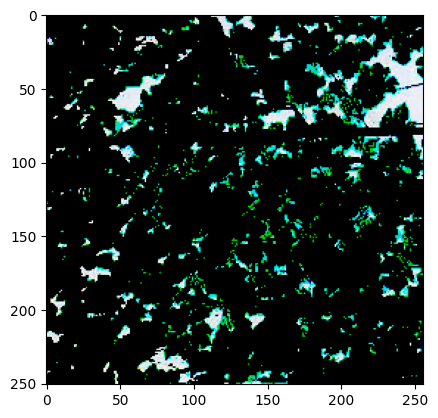

In [9]:
#@title 分けた画像を合成
binde_image=np.empty_like(src)
binde_image[:,:,0]=r_mask
binde_image[:,:,1]=g_mask
binde_image[:,:,2]=b_mask

src2 = cv2.cvtColor(binde_image, cv2.COLOR_BGR2RGB)
plt.imshow(src2)

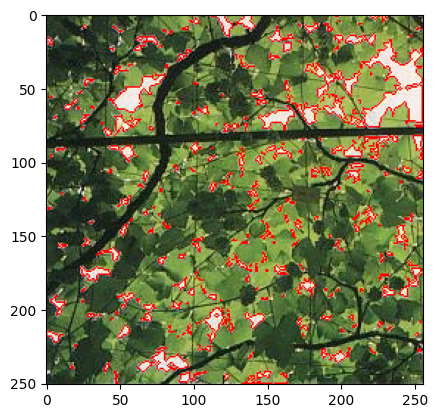

In [15]:
#@title 元の画像に輪郭線を描写
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
import statistics

#@markdown 囲む面積の大きさでノイズを除去する(範囲は0:除去無し～１;全除去)
minimum_area_ratio = 0 # @param {type:"number"}

binde_image_binary=binde_image[:,:,0]+binde_image[:,:,1]+binde_image[:,:,2]

contours, hierarchy = cv2.findContours(binde_image_binary.astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img_with_line = deepcopy(orig)
for i in range(len(contours)):
    if cv2.contourArea(contours[i]) > (src.shape[0] * src.shape[1]) * minimum_area_ratio:
        img_with_line = cv2.drawContours(img_with_line, contours, i, (0,0,255), 1)

plt.imshow(cv2.cvtColor(img_with_line, cv2.COLOR_BGR2RGB))
#cv2.imwrite('allresult_line.png', img_with_line)

白の占める割合は 11 %


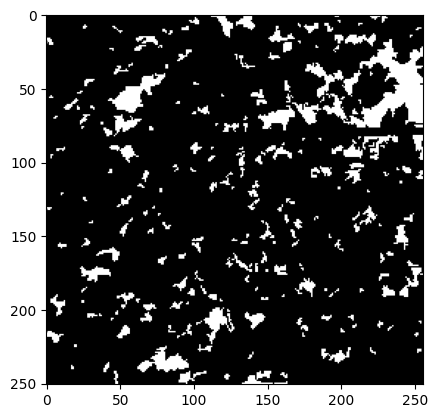

In [16]:
#@title 画面の中の白の割合を計算
import math

img_with_area = deepcopy(np.ones((src.shape[0], src.shape[1], 3), np.uint8)*0)
for i in range(len(contours)):
    if cv2.contourArea(contours[i]) > (src.shape[0] * src.shape[1]) * minimum_area_ratio:
        img_with_area = cv2.fillPoly(img_with_area, [contours[i][:,0,:]], (255,255,255), lineType=cv2.LINE_8, shift=0)
plt.imshow(cv2.cvtColor(img_with_area, cv2.COLOR_BGR2RGB))

img_with_area_binary=img_with_area[:, :, 0]+img_with_area[:, :, 1]+img_with_area[:, :, 2]
img_with_area_binary=np.where(img_with_area_binary > 0, 1, 0)

plt.imshow(img_with_area_binary, cmap='gray')

all_pixcel=img_with_area_binary.shape[0]*img_with_area_binary.shape[1]
sky_pixcel=np.sum(img_with_area_binary)

sky_occupancy_rate=sky_pixcel/all_pixcel
print("白の占める割合は",math.floor(sky_occupancy_rate*100),"%")

In [ ]:
#@title マスク画像をダウンロード
from PIL import Image

#@markdown マスク画像の色をRGBで指定する
Routput = 255 # @param {type:"slider", min:0, max:255, step:1}
Goutput = 255 # @param {type:"slider", min:0, max:255, step:1}
Boutput = 255 # @param {type:"slider", min:0, max:255, step:1}


img_with_area_output=np.empty_like(src)
img_with_area_output[:,:,0]=np.where(img_with_area[:, :, 0] > 0, Routput, 0)
img_with_area_output[:,:,1]=np.where(img_with_area[:, :, 1] > 0, Goutput, 0)
img_with_area_output[:,:,2]=np.where(img_with_area[:, :, 2] > 0, Boutput, 0)

pil_img = Image.fromarray(img_with_area_output)
pil_img.save('/content/binary_'+uploaded_file_name)

files.download('/content/binary_'+uploaded_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>